<a href="https://colab.research.google.com/github/zeroam/jupyter-notebook/blob/master/dive_into_deep_learning/3.11.underfit_overfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- `오버피팅`: 모델이 실제 분포보다 학습 샘플들 분포에 더 근접하게되는 현상
  - 오버피팅을 피하기 위해서는 정규화가 필요
- `언더피팅`: 모델이 너무 간단하기 때문에 학습 오류가 줄어들지 않는 것

In [0]:
!pip install mxnet==1.6.0b20190915
!pip install d2l

In [0]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

In [0]:
maxdegree = 20 # Maximum degree of the polunomial
n_train, n_test = 100, 1000 # Training and test data set sizes
true_w = nd.zeros(maxdegree)
true_w[0:4] = nd.array([5, 1.2, -3.4, 5.6])

features = nd.random.normal(shape=(n_train + n_test, 1))
features = nd.random.shuffle(features)
poly_features = nd.power(features, nd.arange(maxdegree).reshape((1, -1)))
poly_features = poly_features / (
    nd.gamma(nd.arange(maxdegree) + 1).reshape((1, -1))
)
labels = nd.dot(poly_features, true_w)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [4]:
features[:2], poly_features[:2], labels[:2]

(
 [[-0.5095612 ]
  [ 0.34202248]]
 <NDArray 2x1 @cpu(0)>, 
 [[ 1.00000000e+00 -5.09561181e-01  1.29826277e-01 -2.20514797e-02
    2.80914456e-03 -2.86286173e-04  2.43133891e-05 -1.76987987e-06
    1.12732764e-07 -6.38269260e-09  3.25237282e-10 -1.50662070e-11
    6.39762874e-13 -2.50767933e-14  9.12725858e-16 -3.10059752e-17
    9.87465158e-19 -2.95984643e-20  8.37901598e-22 -2.24716890e-23]
  [ 1.00000000e+00  3.42022479e-01  5.84896803e-02  6.66826218e-03
    5.70173899e-04  3.90024543e-05  2.22328640e-06  1.08630559e-07
    4.64426186e-09  1.76493528e-10  6.03647601e-12  1.87691835e-13
    5.34956914e-15  1.40744053e-16  3.43840286e-18  7.84007342e-20
    1.67592608e-21  3.37178999e-23  6.40682259e-25  1.15330363e-26]]
 <NDArray 2x20 @cpu(0)>, 
 [3.8980482 5.3267784]
 <NDArray 2 @cpu(0)>)

In [0]:
# This function has been saved in the d2l package for future use
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
  d2l.set_figsize(figsize)
  d2l.plt.xlabel(x_label)
  d2l.plt.ylabel(y_label)
  d2l.plt.semilogy(x_vals, y_vals)
  if x2_vals and y2_vals:
    d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
    d2l.plt.legend(legend)

In [0]:
num_epochs, loss = 200, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
  net = nn.Sequential()
  # Switch off the bias since we already catered for it in the polynomial features
  net.add(nn.Dense(1, use_bias=False))
  net.initialize()
  batch_size = min(10, train_labels.shape[0])
  train_iter = gdata.DataLoader(gdata.ArrayDataset(
      train_features, train_labels), batch_size, shuffle=True)
  trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
  train_ls, test_ls = [], []
  for _ in range(num_epochs):
    for X, y in train_iter:
      with autograd.record():
        l = loss(net(X), y)
      l.backward()
      trainer.step(batch_size)
    train_ls.append(loss(net(train_features),
                         train_labels).mean().asscalar())
    test_ls.append(loss(net(test_features),
                        test_labels).mean().asscalar())
  print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
  semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
           range(1, num_epochs + 1), test_ls, ['train', 'test'])
  print('weight:', net[0].weight.data().asnumpy())

final epoch: train loss 0.004533334 test loss 0.0051396303
weight: [[ 4.9953218  1.2209328 -3.392673   5.5614953]]


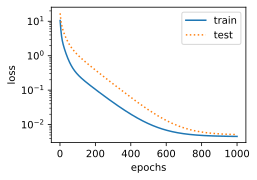

In [13]:
num_epochs = 1000
# Pick the first four dimensions, i.e. 1, x, x^2, x^3 from the polynomial
# features
fit_and_plot(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4],
             labels[:n_train], labels[n_train:])

final epoch: train loss 0.863233 test loss 3.347278
weight: [[ 4.92652    3.3815546 -2.6741695]]


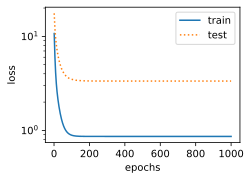

In [14]:
num_epochs = 1000
# Pick the first four dimensions, i.e. 1, x from the polynomial features
fit_and_plot(poly_features[:n_train, 0:3], poly_features[n_train:, 0:3],
             labels[:n_train], labels[n_train:])

final epoch: train loss 0.0051946067 test loss 0.030529931
weight: [[ 4.9593425e+00  1.2565695e+00 -3.2004530e+00  5.2843423e+00
  -6.3787937e-01  1.3263898e+00 -3.4702670e-02  6.8951100e-02
   4.2948000e-02 -1.0939634e-02  6.2713638e-02  3.2563366e-02
   3.5026174e-02 -4.5962017e-02 -2.2482881e-02  2.9453209e-03
  -1.4631407e-03 -6.2392682e-02 -2.2542085e-02 -4.2000487e-02]]


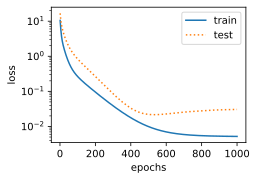

In [15]:
num_epochs = 1000
n_subset = 100 # Subset of data to train on
n_degree = 20 # Degree of polynomials
fit_and_plot(poly_features[1:n_subset, 0:n_degree],
             poly_features[n_train:, 0:n_degree], labels[1:n_subset],
             labels[n_train:])